<a href="https://colab.research.google.com/github/MadhuriMapari/MadhuriMapari/blob/main/pytorch_for_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch for Image Data 

Practice 
1. Working with images in PyTorch
2. Splitting a dataset into training, validation and test sets
3. Creating PyTorch models with custom logic by extending the nn.Module class
4. Interpreting model outputs as probabilities using softmax and picking labels
5. Picking a useful evaluation metric (accuracy) and loss function (cross-entropy) for classification probles
6. Setting up a training loop that also evaluates the model using the validation set 
7. Testing the model manually on randomly picked examples 
8. Saving and loading model checkpoints to avoid retraining from scratch

### Working with Image 

In [ ]:
import torch 
import torchvision 
from torchvision.datasets import MNIST 

In [ ]:
dataset = MNIST(root='data/',download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
len(dataset)

60000

The dataset has 60000 images used to train the model. there is also an additional test test of 10000 images used for evaluating models and reporting matrics in papers and reports. We cancreate the test dataset using the MNIST class by passing train= False to constructor 

In [ ]:
test_dataset = MNIST(root='data/',download=False)

Lets look at sample element

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FAF7A2C1C90>, 5)

Its pair, consisting of 28x28px image and a label. The image is an object of class `PIL.Image.Image`, which is a part of the Python imaging library Pillow.To view the image with Jupyter using `matplotlib` the de-facto plotting and graphing library for data science in python

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

`%matplotlib inline` indicates to jupiter that we want to plot within the notebook. without this line Jupyter will show the image in popup. 

the statements with `%` are called magic commands and are used to onfigure the behaviour of jupyter itself . 

Lets look at some of the images from the dataset.

Label:  5


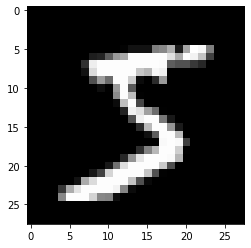

In [ ]:
image,label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label: ',label)

It is evident that these images are relatively small in size, and recognoizing the digits can sometimes be challenging even for human eye. While its useful to look at these images, thses's just one problem here: 

PyTorch doesn't know how to work with images. We need to convert the images into tensors.W can do this by specifying a transformation while creating our dataset.

In [ ]:
import torchvision.transforms as transforms

PyTorch datasets allow to specify one or more transform functions that are applied to theimages as they are loaded.The `torchvision.transforms` module contains many such predefined functions. Here, use the`ToTensor' transform to convert images into Pytorch tensors. 

In [ ]:
# MNIST dataset (images and labels)
dataset = MNIST(root='data/',train=True,transform=transforms.ToTensor())


In [ ]:
img_tensor,label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now converted into 1x28x28 tensor. The first dimension tracks color channels. The second and third dimensions represent pixels along the height and width of the image, respectively. Since image in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are three channels : red, green,and blue(RGB) 

Let's look at the sample value inside the tensor

In [ ]:
print(img_tensor[:,10:15,10:15])
print(torch.max(img_tensor),torch.min(img_tensor))

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


The values range from `0` and `1`, with `0` representing black, `1` white, and the values in between different shades of grey. 

We can also plot the tensor as an image using `plt.imshow` 

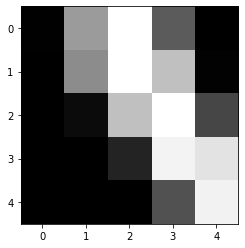

In [ ]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0,10:15,10:15],cmap='gray')

Note that we need to pass just 28x28 matrix to `plt.imshow`,without a channel dimension. We also pass a color map(cmap=gray) to indicate that we want to see a grayscale image.

### Training and Validation Datasets
While building real-world machine learning models, it is quite common to split the dataset into three parts: 
1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
2. **Validation set** - Used to evaluatethe model during training, adjust hyperparameters(learning rate, etc.), and pick the best version of the model.
3. **Test set** - used to compare different models or approaches and report the model's final accuracy.

In the MNIST dataset, there are 60000 training images and 10000 test images. the test set is standardized so that different researchers can report their models results against the same collection of images. 

Since, there's no predefined validation set, we must manually split the 60000 images into training and validation datasets. Let's set aside 10000 randomly chosen images for validation. We can do this using the `random_split` method from PyTorch.


In [ ]:
from torch.utils.data import random_split 

train_ds, val_ds = random_split(dataset, [50000,10000])
len(train_ds),len(val_ds)

(50000, 10000)

It's essential to choose a random sample for creating a validation set. Training data is often sorted by the target labels, i.e.,images of 0s, followed by 1s, followed by 2s, etc. If we create a validation set using the last 20% of images, it would only consist pf 8s and 9s . In contrast, the training set would contain no 8s and 9s. Such a training -validation would make it impossible to train a useful model.

Because we use training data to perform Gradient decent and the validation set is only used for evaluation. they are completely separate in the label set they contain

We can now create data loader to help us load the data in batches. We'll use a batch size of 128. 

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size,shuffle=True)
val_loader = DataLoader(val_ds,batch_size)

Set `shuffle=True` for the training dataloader to ensure that the batches generated in each epoch are different. This randomization helps generalize and speed up the training process. On the other hand, since the validation dataloader is used only for evaluating the model , there is no need to shuffle the images 

 ### Model
 Now that we have prepared our data loaders we can define our model, 
 - A **logistic regression** model is almost identical to linear regression model. It contains weights and bias matrices, and the output is obtained using simple matrix operation(`pred = x @ wT _b `).
 - As we did with linear regression , we can use `nn.Linear` to create the model instead of manually creating and initializing the matrices.
 - Since `nn.Linear` expects each training example to be a vector , each `1x28x28` image tensor is *flattened* into a vector of size 784(`28*28`) 
 - The output for each image is a vector of size 10, with each element signifying the probability of a particular target label(i.e. 0 to 9 ).The predicted label for an image is simply the one with the highest probability.

In [ ]:
import torch.nn as nn

input_size = 28 * 28
num_classes = 10 

#Logistic Regression Model
model = nn.Linear(input_size,num_classes)

Of course, this model is lot larger than previous model in terms of the number of parameters. lets take a look at the weights and biases

In [ ]:
print (model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-0.0347,  0.0204, -0.0040,  ..., -0.0344, -0.0186,  0.0318],
        [ 0.0012,  0.0021,  0.0164,  ..., -0.0168, -0.0065, -0.0195],
        [-0.0214,  0.0356, -0.0043,  ..., -0.0048,  0.0296, -0.0266],
        ...,
        [ 0.0192, -0.0027, -0.0108,  ...,  0.0091, -0.0012, -0.0266],
        [ 0.0211,  0.0012, -0.0186,  ..., -0.0291, -0.0335,  0.0314],
        [ 0.0111,  0.0044,  0.0149,  ...,  0.0177, -0.0169,  0.0328]],
       requires_grad=True)

In [ ]:
print (model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0088, -0.0198,  0.0199, -0.0170,  0.0013,  0.0140,  0.0176,  0.0355,
         0.0133, -0.0301], requires_grad=True)

Although there are a total of 7850 parameters here, conceptually, nothing has changes so far.Let's try and generate some outputs using our model. We'll take the first batch of 100 images from our dataset and pass them into our model.

In [ ]:
for images, labels in train_loader:
  print(labels)
  print(images.shape)
  outputs = model(images)
  break

tensor([7, 5, 2, 9, 3, 3, 7, 1, 9, 7, 4, 1, 4, 9, 7, 2, 8, 0, 0, 0, 6, 4, 3, 6,
        0, 3, 7, 9, 5, 4, 6, 1, 0, 9, 4, 7, 5, 7, 7, 0, 4, 7, 7, 5, 5, 6, 5, 2,
        0, 0, 6, 5, 4, 5, 6, 8, 9, 0, 5, 4, 0, 4, 2, 7, 7, 8, 7, 7, 7, 8, 1, 2,
        4, 7, 2, 9, 4, 4, 8, 8, 3, 3, 0, 9, 4, 4, 2, 6, 7, 2, 3, 7, 2, 4, 7, 7,
        5, 4, 6, 2, 2, 6, 7, 2, 6, 6, 2, 0, 2, 4, 7, 7, 8, 3, 4, 8, 4, 1, 9, 1,
        0, 3, 3, 1, 6, 8, 1, 0])
torch.Size([128, 1, 28, 28])


RuntimeError: ignored

The code above leads to an error because our input data does not have the right shape. Our images are of the shape 1x28x28, but we need them to be vectors of size 784, i.e., we need to flatten them. We'll use the `.reshape` method of a tensor, which will allow us to efficiently 'view' each image as a flat vector without really creating a copy of the underlying data. To include this additional functionality within our model, we need to define a custom model by extending the nn.Module class from PyTorch

A class in python provides a "blueprint" for creating objects. Lets look at an example of defining a new class in python

In [ ]:
images.shape

torch.Size([128, 1, 28, 28])

In [ ]:
images.reshape(128,784).shape


torch.Size([128, 784])

Let's extend the nn.Module class from PyTorch to define a custom model

In [ ]:
class MNISTModel(nn.Module):
  #class constructor
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size,num_classes)

  def forward(self, xb):
    xb = xb.reshape(-1,784)
    out = self.linear(xb)
    return out

model = MNISTModel()

Inside the `__init__` constructor method, we instantiate the weights and biases using nn.Linear. And inside the `forward` method, which is invoked when we pass a batch a inputs to the model, we flatten the input tensor and pass it into `self.linear`.

**Note** : the model no longer has `.weight` and `.bias` attributes(as they are now inside the `.linear` attribute), but it does have a `.parameters` method that returns a list containing the weights and bias.

In [ ]:
print(model.linear.weight.shape,model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[-0.0338,  0.0301, -0.0317,  ..., -0.0086, -0.0062, -0.0256],
         [-0.0341,  0.0091,  0.0170,  ..., -0.0255, -0.0111, -0.0280],
         [-0.0121, -0.0021,  0.0357,  ...,  0.0054, -0.0206, -0.0323],
         ...,
         [-0.0043,  0.0281,  0.0252,  ..., -0.0072,  0.0151,  0.0010],
         [ 0.0125,  0.0177, -0.0042,  ...,  0.0213,  0.0170, -0.0316],
         [-0.0195, -0.0263,  0.0108,  ..., -0.0336, -0.0016,  0.0225]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0072,  0.0071,  0.0052, -0.0112,  0.0027, -0.0342, -0.0180, -0.0164,
         -0.0099,  0.0030], requires_grad=True)]

Use new custom model in the same way as above 

In [ ]:
for images, labels in train_loader:
  outputs = model(images)
  break
print('outputs.shape : ',outputs.shape)
print('Sample outputs : \n',outputs[:2].data)

outputs.shape :  torch.Size([128, 10])
Sample outputs : 
 tensor([[-0.2433, -0.0106,  0.1387,  0.0495, -0.2793,  0.0337, -0.1370, -0.0974,
         -0.0288,  0.2998],
        [-0.3025, -0.3151,  0.1161, -0.1031, -0.1016,  0.0881, -0.0536,  0.1837,
         -0.3550,  0.1258]])


For each of the 100 input images, we get 10 outputs, one for each class. As discussed earlier, we'd like these outputs to represent probabilities. Each output row's elements must lie between 0 to 1 and addupto 1, which is not the case.

To convert the output rowas into probabilities , we use the softmax function.

In [ ]:
import math
import numpy as np


def softmax(outputs):
  probsList = []
  
  
  for output in outputs:
    esum = 0
    probs = []
    for val in output:
        esum += math.exp(val)
    for val in output:   
        probs.append(round((math.exp(val)) / esum,4))
      
    probsList.append( np.array(probs))
  arr = np.array(probsList)
  return  torch.from_numpy(arr)

In [ ]:
import torch.nn.functional as F

In [ ]:
# Apply Softmax for each output row
probs_1 = F.softmax(outputs,dim=1)

probs_2 = softmax(outputs,dim=1)
probs_1,probs_2

(tensor([[0.0795, 0.1003, 0.1165,  ..., 0.0920, 0.0985, 0.1368],
         [0.0780, 0.0770, 0.1185,  ..., 0.1268, 0.0740, 0.1197],
         [0.0793, 0.0853, 0.1469,  ..., 0.1142, 0.1191, 0.1116],
         ...,
         [0.0755, 0.1073, 0.0854,  ..., 0.1250, 0.1048, 0.0959],
         [0.0727, 0.0618, 0.1035,  ..., 0.1718, 0.1038, 0.0912],
         [0.0891, 0.0911, 0.1004,  ..., 0.1129, 0.0866, 0.1049]],
        grad_fn=<SoftmaxBackward>),
 tensor([[0.0795, 0.1003, 0.1165,  ..., 0.0920, 0.0985, 0.1368],
         [0.0780, 0.0770, 0.1185,  ..., 0.1268, 0.0740, 0.1197],
         [0.0793, 0.0853, 0.1469,  ..., 0.1142, 0.1191, 0.1116],
         ...,
         [0.0755, 0.1073, 0.0854,  ..., 0.1250, 0.1048, 0.0959],
         [0.0727, 0.0618, 0.1035,  ..., 0.1718, 0.1038, 0.0912],
         [0.0891, 0.0911, 0.1004,  ..., 0.1129, 0.0866, 0.1049]],
        dtype=torch.float64))

Finally , we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. We can do this using the `torch.max`, which returns each row's largest element and the corresponding index.

In [ ]:
max_probs,preds = torch.max(probs_2, dim = 1)
print(preds)
print(max_probs)

tensor([9, 7, 2, 8, 2, 7, 9, 7, 7, 8, 4, 7, 7, 2, 5, 8, 6, 7, 7, 7, 2, 3, 7, 9,
        7, 9, 8, 7, 1, 7, 7, 9, 7, 8, 6, 9, 7, 9, 9, 7, 7, 8, 7, 7, 9, 9, 4, 7,
        9, 2, 9, 7, 8, 9, 9, 7, 8, 2, 7, 8, 8, 7, 2, 9, 7, 7, 1, 7, 8, 1, 6, 2,
        8, 9, 8, 2, 7, 8, 8, 7, 7, 3, 9, 9, 6, 5, 9, 9, 7, 9, 7, 7, 2, 7, 2, 2,
        8, 9, 7, 5, 8, 8, 9, 7, 8, 2, 9, 8, 9, 5, 7, 7, 6, 7, 7, 5, 8, 8, 7, 7,
        3, 9, 7, 2, 8, 6, 7, 4])
tensor([0.1368, 0.1268, 0.1469, 0.1549, 0.1298, 0.1549, 0.1312, 0.1582, 0.1424,
        0.1176, 0.1137, 0.1360, 0.1732, 0.1223, 0.1172, 0.1316, 0.1201, 0.1306,
        0.1359, 0.1303, 0.1373, 0.1284, 0.1264, 0.1170, 0.1191, 0.1476, 0.1682,
        0.1585, 0.1144, 0.1431, 0.1410, 0.1596, 0.1306, 0.1447, 0.1267, 0.1177,
        0.1218, 0.1404, 0.1193, 0.1413, 0.1352, 0.1240, 0.1241, 0.1531, 0.1329,
        0.1259, 0.1212, 0.1407, 0.1273, 0.1166, 0.1246, 0.1518, 0.1341, 0.1328,
        0.1288, 0.1565, 0.1374, 0.1339, 0.1559, 0.1408, 0.1414, 0.1433, 0.1484,
       

The numbers printed above are the predicted labels for the first batch of training images. Let's compare it with actual labels

In [ ]:
labels

tensor([1, 6, 0, 7, 5, 4, 8, 5, 0, 9, 7, 2, 7, 1, 9, 9, 3, 3, 6, 3, 0, 6, 8, 7,
        9, 1, 2, 5, 3, 7, 9, 2, 5, 9, 4, 3, 5, 2, 9, 3, 2, 9, 6, 6, 9, 1, 4, 7,
        4, 1, 1, 6, 5, 3, 8, 8, 3, 8, 5, 9, 4, 6, 0, 8, 7, 4, 9, 5, 7, 9, 5, 5,
        8, 6, 1, 0, 2, 9, 8, 5, 3, 2, 8, 7, 5, 7, 0, 2, 0, 1, 0, 3, 0, 3, 0, 2,
        7, 1, 1, 2, 1, 7, 9, 3, 4, 6, 1, 5, 7, 4, 4, 2, 3, 7, 6, 3, 5, 9, 8, 2,
        6, 1, 6, 1, 2, 5, 0, 5])

Most of the predicted labels are different from the actual labels. That's because we have started with randomly initialized weights and biases. we need to train the model, i.e. adjust the weights using gradient decent to make better predictions. 

### Evaluation Metric and Loss Function


As with Linear Regression, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly , i.e., the **accuracy** of the predictions

In [ ]:
def accuracy(outputs, labels):
  _,preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

the `==` operator performs an element wise comparision of two tensors with the same shape and returns a tensor of same shape, containing `True` for unequal elements and `False` for equal elements. Passing the result to `torch.sum` returns the number of labels that were predicted correctly.Finally , we divide by the total number of images to get the accuracy.

Note: softmax need not be applied to the outputs since its results have the same relative order. this is because '$e^x$' is an increasing function,i.e., if y1 > y2, then $e^{y1}$ > $e^{y2}$. The same  holds after avaeraging out the values to get the softmax. 

Let's calculate the accuracy of the current model on the first batch of data.

In [ ]:
accuracy(outputs,labels)

tensor(0.0938)

Accuracy is an excellent way for us to evaluate the model.However, we can't use it as a loss function for optimizing our model using the gradient descent for tht following reasons:
1. It's not differentiable function. torch.max and == are both noncontinuous and non differentiable operations , so we can't use the accuracy for computing gradients w.r.t the weights and biases.
2. It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements.

For these reasons accuracy is often used as an **evaluation metric** for classification,but not as a loss function. A commonly used loss function for classification problem is the **cross-entropy**,

\begin{align}
\mathbf{D(\hat{y},y)} = -\sum_{j}{y_j}\ln{\hat{y_j}}
\end{align}
 
As per this formula,
- for each output row, pick the predicted probability for the correct label. E.g., if the predicted probabilities for an image are [0.1,0.3,0.2,...] and the correct label is 1, we pick the corresponding element 0.3 and ignore the rest. 
- Then, take the logarithm of the picked probability. If the probability is high i.e., close to 1, then its logarithm is avery small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1 , which results in a large positive value of the loss for poor predictions.
- Finally, take the average of the cross  entropy across all the output rows to get the overall loss for a batch of data.

Unlike Accuracy, cross-entropy is a continuous and differentiable function. It also provides useful feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). These two factors make cross-entropy a better choice for the loss function.

As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross-entropy as part of the `torch.nn.functional` package. Moreover, it also performs softmax internally, so the model's outputs can be passed directly without converting them into probabilities


In [ ]:
loss_fn = F.cross_entropy

In [ ]:
# Loss for current batch of data
loss = loss_fn(outputs,labels)
print(loss)

tensor(2.3139, grad_fn=<NllLossBackward>)


We know that cross-entropy is the negative logarithm of the predicted probability of the correct label averaged over all training samples. Therefore, one way to interpret the resulting number e.g. `2.31` is look as $e^{-2.31}$ which is around `0.1` as the predicted probability of the correct label, on average. *Lower the loss, Better the model*.

### Training the model

After defining the dataloaders, model, loss function and optimizer, we are ready to train the model.The training process is identical to linear regression with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

```
for epoch in range(num_epochs )
  # Training phase
  for batch in train_loader:
    # Generate predictions
    # Calculate loss
    # Compute gradients
    # Update weights
    # Reset gradients
  
  # Validation phase
  for batch in val_loader:
    # Generate predictions
    # Calculate loss
    # Calculate metrics (accuracy etc.)
  
  # Calculate average validation loss & metrics 

  # Log epoch, loss & metrics for inspection

```
Some parts of the training loop are specific,  the specific problem we're solving(e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem.
We'll include the problem-independent parts within a function called `fit`, which will be used to train the model. The problem-specific parts will be implemented by adding new methods to the nn.Module class.  

In [ ]:
def fit(epochs,lr,model,train_loader,val_loader,opt_func=torch.optim.SGD):
  optimizer = opt_func(model.parameters(),lr)
  history = [] # for recording epoch-wise results

  for epoch in range(epochs):

    # Training Phase
    for batch in train_loader:

        # Generate predictions and Calculate loss
        loss = model.training_step()

        # Compute gradients
        loss.backward()

        # Update weights
        optimizer.step()

        # Reset gradients
        optimizer.zero_grad()

    # Validation phase
    for batch in val_loader:
        # Generate predictions and Calculate loss and accuracy
        result = evaluation(model,val_loader)
        
        # Calculate metrics (accuracy etc.)
        model.epoch_end(epoch,result)
        history.append(result)
    
  return history 
    


In [ ]:
for epoch in range(num_epochs ):
  # Training phase
  for batch in train_loader:

    images, labels = batch
    # Generate predictions
    outputs = model(images)

    # Calculate loss
    loss = loss_fn(outputs,labels)

    # Compute gradients
    loss.backward()

    # Update weights
    model.forward(images)

    # Reset gradients
        model.linear.weight.shape
    model.linear.bias.shape

  # Validation phase
  for batch in val_loader:

    images, labels = batch
    # Generate predictions
    outputs = model(images)

    # Calculate loss
    loss = loss_fn(outputs,labels)

    # Calculate metrics (accuracy etc.)
    print(accuracy(outputs,labels))
  
  # Calculate average validation loss & metrics 

  # Log epoch, loss & metrics for inspection

SyntaxError: ignored